# Load data

In [1]:
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [2]:
# Transformations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load train set
train_set = dsets.CIFAR10('../', train=True, download=True, transform=transform_train)

# Load test set (using as validation)
val_set = dsets.CIFAR10('../', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
import sys
print(sys.path)
sys.path.append('c:/Users/bryan/fastshap')

['c:\\Users\\bryan\\fastshap\\notebooks', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\\python310.zip', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\\DLLs', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\\lib', 'C:\\Users\\bryan\\AppData\\Local\\Microsoft\\WindowsApps\\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0', '', 'C:\\Users\\bryan\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python310\\site-packages', 'C:\\Users\\bryan\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python310\\site-packages\\win32', 'C:\\Users\\bryan\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python310\\site-packages\\win32\\lib', 'C:\\Users\\bryan\\AppData\\Loca

# Train model with missingness

In [4]:
import torch
import torch.nn as nn
import os.path
from resnet import ResNet18
from fastshap import ImageSurrogate
from fastshap.utils import MaskLayer2d, KLDivLoss, DatasetInputOnly

In [5]:
# Select device
device = torch.device('cuda')

In [6]:
# Check for model
if os.path.isfile('cifar missingness.pt'):
    print('Loading saved model')
    model = torch.load('cifar missingness.pt').to(device)
    imputer = ImageSurrogate(model, width=32, height=32, superpixel_size=2)

else:
    # Create model
    model = nn.Sequential(
        MaskLayer2d(value=0, append=True),
        ResNet18(in_channels=4, num_classes=10)).to(device)
    
    # familiariaze with DataLoader
    # Set up surrogate wrapper (although this is not a surrogate model)
    imputer = ImageSurrogate(model, width=32, height=32, superpixel_size=2)

    # Train
    imputer.train(train_set,
                  val_set,
                  batch_size=256,
                  max_epochs=100,
                  loss_fn=nn.CrossEntropyLoss(),
                  lookback=10,
                  bar=True,
                  verbose=True)
    
    # Save model
    model.cpu()
    torch.save(model, 'cifar missingness.pt')
    model.to(device)

Loading saved model


# Train FastSHAP

In [7]:
from unet import UNet
from fastshap import FastSHAP

In [8]:
# Check for model
if os.path.isfile('cifar missingness explainer.pt'):
    print('Loading saved explainer model')
    explainer = torch.load('cifar missingness explainer.pt').to(device)
    fastshap = FastSHAP(explainer, imputer, link=nn.LogSoftmax(dim=1))

else:
    # Set up explainer model
    explainer = UNet(n_classes=10, num_down=2, num_up=1, num_convs=3).to(device)

    # Set up FastSHAP object
    fastshap = FastSHAP(explainer, imputer, link=nn.LogSoftmax(dim=1))

    # Set up datasets
    # the train and val set are just the CIFAR dataset
    fastshap_train = DatasetInputOnly(train_set)
    fastshap_val = DatasetInputOnly(val_set)

    # Train
    fastshap.train(
        fastshap_train,
        fastshap_val,
        batch_size=128,
        num_samples=2,
        max_epochs=200,
        eff_lambda=1e-2,
        validation_samples=1,
        lookback=10,
        bar=True,
        verbose=True)
    
    # Save explainer
    explainer.cpu()
    torch.save(explainer, 'cifar missingness explainer.pt')
    explainer.to(device)

Loading saved explainer model


# Visualize results

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [10]:
def calculate_exclusion(values, samples, targets):
    #del mask
    # print(len(targets))
    # print(values.shape)
    targets = torch.tensor(targets)
    inclusion_auc = []
    sorted_val = torch.zeros((len(values), 256))
    for i in range(len(values)):
        sorted_val[i] = torch.sort(values[i, targets[i]].flatten(), descending=True)[0]

    inclusion_percentages = torch.linspace(0, 1, len(sorted_val[0])+1)
    # print(sorted_val)
    # print(inclusion_percentages)
    # del e
    top1_accuracies = []
    values = values[torch.arange(len(values)), targets]
    for threshold in inclusion_percentages:
        print(threshold)
        # Create binary mask for the top features
        mask = (values >= sorted_val[:,int(threshold * (len(sorted_val[0])-1))].unsqueeze(1).unsqueeze(2))
        # print(threshold)
        #print(f'{threshold}:{mask}')
        mask = mask.reshape(-1)
        # print(mask.shape)
        mask = mask.view((len(values), 256))
        S = torch.ones(len(values), imputer.num_players, device=device)
        S[mask] = 0
        #print(S)
        output = imputer(samples.to(device), S).softmax(dim=1).cpu().data
        
        # Compute top-1 accuracy
        _, predicted = torch.max(output, dim=1)
        predicted = torch.tensor(predicted)
        #print(predicted)
        correct = (predicted == targets).sum().item()
        accuracy = correct / len(values)
        
        top1_accuracies.append(accuracy)
        del S, output, predicted, correct, accuracy, mask
        
    # Compute AUC for inclusion percentages vs. top-1 accuracies curve
    top1_accuracies=torch.tensor(top1_accuracies)
    auc = torch.trapz(top1_accuracies, inclusion_percentages)
    inclusion_auc.append(auc)

    # Compute average inclusion AUC across all instances
    average_auc = torch.mean(torch.tensor(inclusion_auc))
    #print(inclusion_auc)
    print("Average exclusion AUC:", average_auc.item())
    del top1_accuracies, inclusion_auc, sorted_val, values
    return average_auc

In [11]:
def calculate_inclusion(values, samples, targets):
    targets = torch.tensor(targets)
    inclusion_auc = []
    sorted_val = torch.zeros((len(values), 256))
    for i in range(len(values)):
        sorted_val[i] = torch.sort(values[i, targets[i]].flatten(), descending=True)[0]

    inclusion_percentages = torch.linspace(0, 1, len(sorted_val[0])+1)
    # print(sorted_val)
    # print(inclusion_percentages)
    # del e
    top1_accuracies = []
    values = values[torch.arange(len(values)), targets]
    for threshold in inclusion_percentages:
        print(threshold)
        # Create binary mask for the top features
        mask = (values < sorted_val[:,int(threshold * (len(sorted_val[0])-1))].unsqueeze(1).unsqueeze(2))
        # print(threshold)
        #print(f'{threshold}:{mask}')
        mask = mask.reshape(-1)
        # print(mask.shape)
        mask = mask.view((len(values), 256))
        S = torch.ones(len(values), imputer.num_players, device=device)
        S[mask] = 0
        #print(S)
        output = imputer(samples.to(device), S).softmax(dim=1).cpu().data
        
        # Compute top-1 accuracy
        _, predicted = torch.max(output, dim=1)
        predicted = torch.tensor(predicted)
        #print(predicted)
        correct = (predicted == targets).sum().item()
        accuracy = correct / len(values)
        
        top1_accuracies.append(accuracy)
        del S, output, predicted, correct, accuracy, mask
    # Compute AUC for inclusion percentages vs. top-1 accuracies curve
    top1_accuracies=torch.tensor(top1_accuracies)
    auc = torch.trapz(top1_accuracies, inclusion_percentages)
    inclusion_auc.append(auc)

    # Compute average inclusion AUC across all instances
    average_auc = torch.mean(torch.tensor(inclusion_auc))
    #print(inclusion_auc)
    print("Average inclusion AUC:", average_auc.item())
    del top1_accuracies, inclusion_auc, sorted_val, values
    return average_auc

In [ ]:
# Select one image from each class
# import torch
# foo = torch.tensor([1,2,3])
# foo = foo.to('cuda')
# del fastshap
# import gc

# gc.collect()
# del S, output, predicted, correct, accuracy, mask
# del top1_accuracies, inclusion_auc, sorted_val, values
# torch.cuda.empty_cache()
dset = val_set
samples = np.array(dset.data)
targets = np.array(dset.targets)
num_classes = targets.max() + 1
inds_lists = [np.where(targets == cat)[0] for cat in range(num_classes)]
inds = [np.random.choice(cat_inds) for cat_inds in inds_lists]
x, y = zip(*list(dset))
x = torch.stack(x)

# # Get explanations
# values = torch.tensor(fastshap.shap_values(x.to(device)))
# print(values.shape)
# sorted_val = []
# sorted_masks = []
# for i in range(len(values)):
#     sorted_val.append(values[i][i].flatten())
#     sorted_val[i] = sorted(sorted_val[i], reverse=True)
#     temp_coord = []
#     for j in range(len(sorted_val[i])):
#         mask = (values[i][i] == sorted_val[i][j])
#         #print(mask)
#         temp_coord.append(mask)
#     sorted_masks.append(temp_coord)
#     print(len(sorted_val))

# eval_x = x
# print(eval_x.shape)
# top1_accuracies = []
# for i in range(len(sorted_val[i])):
#     for j in range(len(sorted_val)):
#         mask = sorted_masks[j][0]
#         print(mask)
#         downsampled_tensor = F.interpolate(eval_x, (16, 16), mode='bilinear', align_corners=False)
#         downsampled_tensor[j,:,mask] = 100
#         eval_x = F.interpolate(downsampled_tensor, (32, 32), mode='bilinear', align_corners=False)

import torch
import torch.nn.functional as F

# Assuming values is your SHAP values tensor with shape (batch_size, num_classes, num_features, height, width)
#values = torch.tensor(fastshap.shap_values(x.to(device)))
#values_val = torch.tensor(fastshap.shap_values(x.to(device)))

values_val = torch.load('values_val.pt')
print("Shape of SHAP values tensor:", values_val.shape)
# average_exclusion = 0
# for i in range(0, 10000, 1000):
#     print(i)
#     average_exclusion += calculate_exclusion(values_val[i:i+1000], x[i:i+1000], y[i:i+1000])
# print(average_exclusion / 10)

average_inclusion = 0
for i in range(0, 10000, 2000):
    print(i)
    average_inclusion += calculate_inclusion(values_val[i:i+2000], x[i:i+2000], y[i:i+2000])
print(average_inclusion / 5)




# basically get the classification accuracy of the imputer model whenever as you remove the top included pixel features and map this
# do this for all the images
# we have the way to get top pixel imp values at the top



# Get predictions
# pred = imputer(
#     x.to(device),
#     torch.ones(num_classes, imputer.num_players, device=device)
# ).softmax(dim=1).cpu().data.numpy()

# fig, axarr = plt.subplots(num_classes, num_classes + 1, figsize=(22, 20))

# for row in range(num_classes):
#     # Image
#     classes = ['Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
#     mean = np.array([0.4914, 0.4822, 0.4465])[:, np.newaxis, np.newaxis]
#     std = np.array([0.2023, 0.1994, 0.2010])[:, np.newaxis, np.newaxis]
#     im = x[row].numpy() * std + mean
#     im = im.transpose(1, 2, 0).astype(float)
#     im = np.clip(im, a_min=0, a_max=1)
#     axarr[row, 0].imshow(im, vmin=0, vmax=1)
#     axarr[row, 0].set_xticks([])
#     axarr[row, 0].set_yticks([])
#     axarr[row, 0].set_ylabel('{}'.format(classes[y[row]]), fontsize=14)
    
#     # Explanations
#     m = np.abs(values[row]).max()
#     for col in range(num_classes):
#         axarr[row, col + 1].imshow(values_val[row, col], cmap='seismic', vmin=-m, vmax=m)
#         axarr[row, col + 1].set_xticks([])
#         axarr[row, col + 1].set_yticks([])
#         if col == y[row]:
#             axarr[row, col + 1].set_xlabel('{:.2f}'.format(pred[row, col]), fontsize=12, fontweight='bold')
#         else:
#             axarr[row, col + 1].set_xlabel('{:.2f}'.format(pred[row, col]), fontsize=12)
        
#         # Class labels
#         if row == 0:
#             axarr[row, col + 1].set_title('{}'.format(classes[y[col]]), fontsize=14)

# plt.tight_layout()
# plt.show()

del values_val

Shape of SHAP values tensor: torch.Size([10000, 10, 16, 16])
0
tensor(0.)


C:\Users\bryan\AppData\Local\Temp\ipykernel_33612\2082005005.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted = torch.tensor(predicted)


tensor(0.0039)
tensor(0.0078)
tensor(0.0117)
tensor(0.0156)
tensor(0.0195)
tensor(0.0234)
tensor(0.0273)
tensor(0.0312)
tensor(0.0352)
tensor(0.0391)
tensor(0.0430)
tensor(0.0469)
tensor(0.0508)
tensor(0.0547)
tensor(0.0586)
tensor(0.0625)
tensor(0.0664)
tensor(0.0703)
tensor(0.0742)
tensor(0.0781)
tensor(0.0820)
tensor(0.0859)
tensor(0.0898)
tensor(0.0938)
tensor(0.0977)
tensor(0.1016)
tensor(0.1055)
tensor(0.1094)
tensor(0.1133)
tensor(0.1172)
tensor(0.1211)
tensor(0.1250)
tensor(0.1289)
tensor(0.1328)
tensor(0.1367)
tensor(0.1406)
tensor(0.1445)
tensor(0.1484)
tensor(0.1523)
tensor(0.1562)
tensor(0.1602)
tensor(0.1641)
tensor(0.1680)
tensor(0.1719)
tensor(0.1758)
tensor(0.1797)
tensor(0.1836)
tensor(0.1875)
tensor(0.1914)
tensor(0.1953)
tensor(0.1992)
tensor(0.2031)
tensor(0.2070)
tensor(0.2109)
tensor(0.2148)
tensor(0.2188)
tensor(0.2227)
tensor(0.2266)
tensor(0.2305)
tensor(0.2344)
tensor(0.2383)
tensor(0.2422)
tensor(0.2461)
tensor(0.2500)
tensor(0.2539)
tensor(0.2578)
tensor(0.2

In [ ]:
print(average_exclusion/10)

NameError: name 'average_exclusion' is not defined

In [ ]:
# def calculate_exclusion(values, samples, targets):
#     inclusion_auc = []

#     for i in range(len(values)):
#         # Sort SHAP values for each instance
#         print(i)
#         sorted_val = torch.sort(values[i, targets[i]].flatten(), descending=True)[0]
#         #print(sorted_val)
        
#         # Compute inclusion percentage thresholds
#         inclusion_percentages = torch.linspace(0, 1, len(sorted_val) + 1)
#         #print(inclusion_percentages)
        
#         top1_accuracies = []
#         # Iterate over inclusion percentage thresholds

#         for threshold in inclusion_percentages:
#             # Create binary mask for the top features
#             # print(values[i, targets[i]])
#             #print(f'{i}:{sorted_val[int(threshold * (len(sorted_val)-1))]}')
#             mask = values[i, targets[i]] >= sorted_val[int(threshold * (len(sorted_val)-1))]
#             mask = mask.reshape(-1)
#             mask = mask.view((1, 256))
#             print(mask)
            
#             # Upsample binary mask if necessary
#             #mask = F.interpolate(mask.unsqueeze(0).unsqueeze(0).float(), (32, 32), mode='nearest').bool()
            
#             # Apply mask to input image
#             # masked_image = x.clone()[i]
#             # masked_image[:, mask[0][0]] = 100  # Example modification
            
#             # Downsample masked image (if needed) and perform inference
#             #downsampled_image = F.interpolate(masked_image, (16, 16), mode='bilinear', align_corners=False)
#             S = torch.ones(1, imputer.num_players, device=device)
#             S[mask] = 0
#             #print(S)
#             output = imputer(samples[i].to(device), S).softmax(dim=1).cpu().data
            
#             # Compute top-1 accuracy
#             _, predicted = torch.max(output, dim=1)
#             #print(predicted)
#             correct = (predicted == targets[i]).sum().item()
#             accuracy = correct
            
#             top1_accuracies.append(accuracy)
#             del S, mask, accuracy
        
#         # Compute AUC for inclusion percentages vs. top-1 accuracies curve
#         top1_accuracies=torch.tensor(top1_accuracies)
#         auc = torch.trapz(top1_accuracies, inclusion_percentages)
#         inclusion_auc.append(auc)

#     # Compute average inclusion AUC across all instances
#     average_auc = torch.mean(torch.tensor(inclusion_auc))
#     #print(inclusion_auc)
#     print("Average exclusion AUC:", average_auc.item())
#     del top1_accuracies, sorted_val, inclusion_percentages, inclusion_auc

In [ ]:
# def calculate_inclusion(values, samples, targets):
#     inclusion_auc = []

#     for i in range(len(values)):
#         # Sort SHAP values for each instance
#         print(i)
#         sorted_val = torch.sort(values[i, targets[i]].flatten(), descending=True)[0]
#         #print(sorted_val)
        
#         # Compute inclusion percentage thresholds
#         inclusion_percentages = torch.linspace(0, 1, len(sorted_val) + 1)
#         #print(inclusion_percentages)
        
#         top1_accuracies = []
#         # Iterate over inclusion percentage thresholds

#         for threshold in inclusion_percentages:
#             # Create binary mask for the top features
#             # what I changed for exclusion is that there is a < instead of a >=
#             mask = values[i, targets[i]] < sorted_val[int(threshold * (len(sorted_val)-1))]
#             mask = mask.reshape(-1)
#             mask = mask.view((1, 256))
#             #print(mask.shape)
            
#             # Upsample binary mask if necessary
#             #mask = F.interpolate(mask.unsqueeze(0).unsqueeze(0).float(), (32, 32), mode='nearest').bool()
            
#             # Apply mask to input image
#             # masked_image = x.clone()[i]
#             # masked_image[:, mask[0][0]] = 100  # Example modification
            
#             # Downsample masked image (if needed) and perform inference
#             #downsampled_image = F.interpolate(masked_image, (16, 16), mode='bilinear', align_corners=False)
#             S = torch.ones(1, imputer.num_players, device=device)
#             S[mask] = 0
#             #print(S)
#             output = imputer(samples[i].to(device), S).softmax(dim=1).cpu().data
            
#             # Compute top-1 accuracy
#             _, predicted = torch.max(output, dim=1)
#             #print(predicted)
#             correct = (predicted == targets[i]).sum().item()
#             accuracy = correct
            
#             top1_accuracies.append(accuracy)
        
#         # Compute AUC for inclusion percentages vs. top-1 accuracies curve
#         top1_accuracies=torch.tensor(top1_accuracies)
#         auc = torch.trapz(top1_accuracies, inclusion_percentages)
#         inclusion_auc.append(auc)

#     # Compute average inclusion AUC across all instances
#     average_auc = torch.mean(torch.tensor(inclusion_auc))
#     #print(inclusion_auc)
#     print("Average inclusion AUC:", average_auc.item())

Shape of SHAP values tensor: torch.Size([10, 10, 16, 16])
0
tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
          True, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,

NameError: name 'values' is not defined

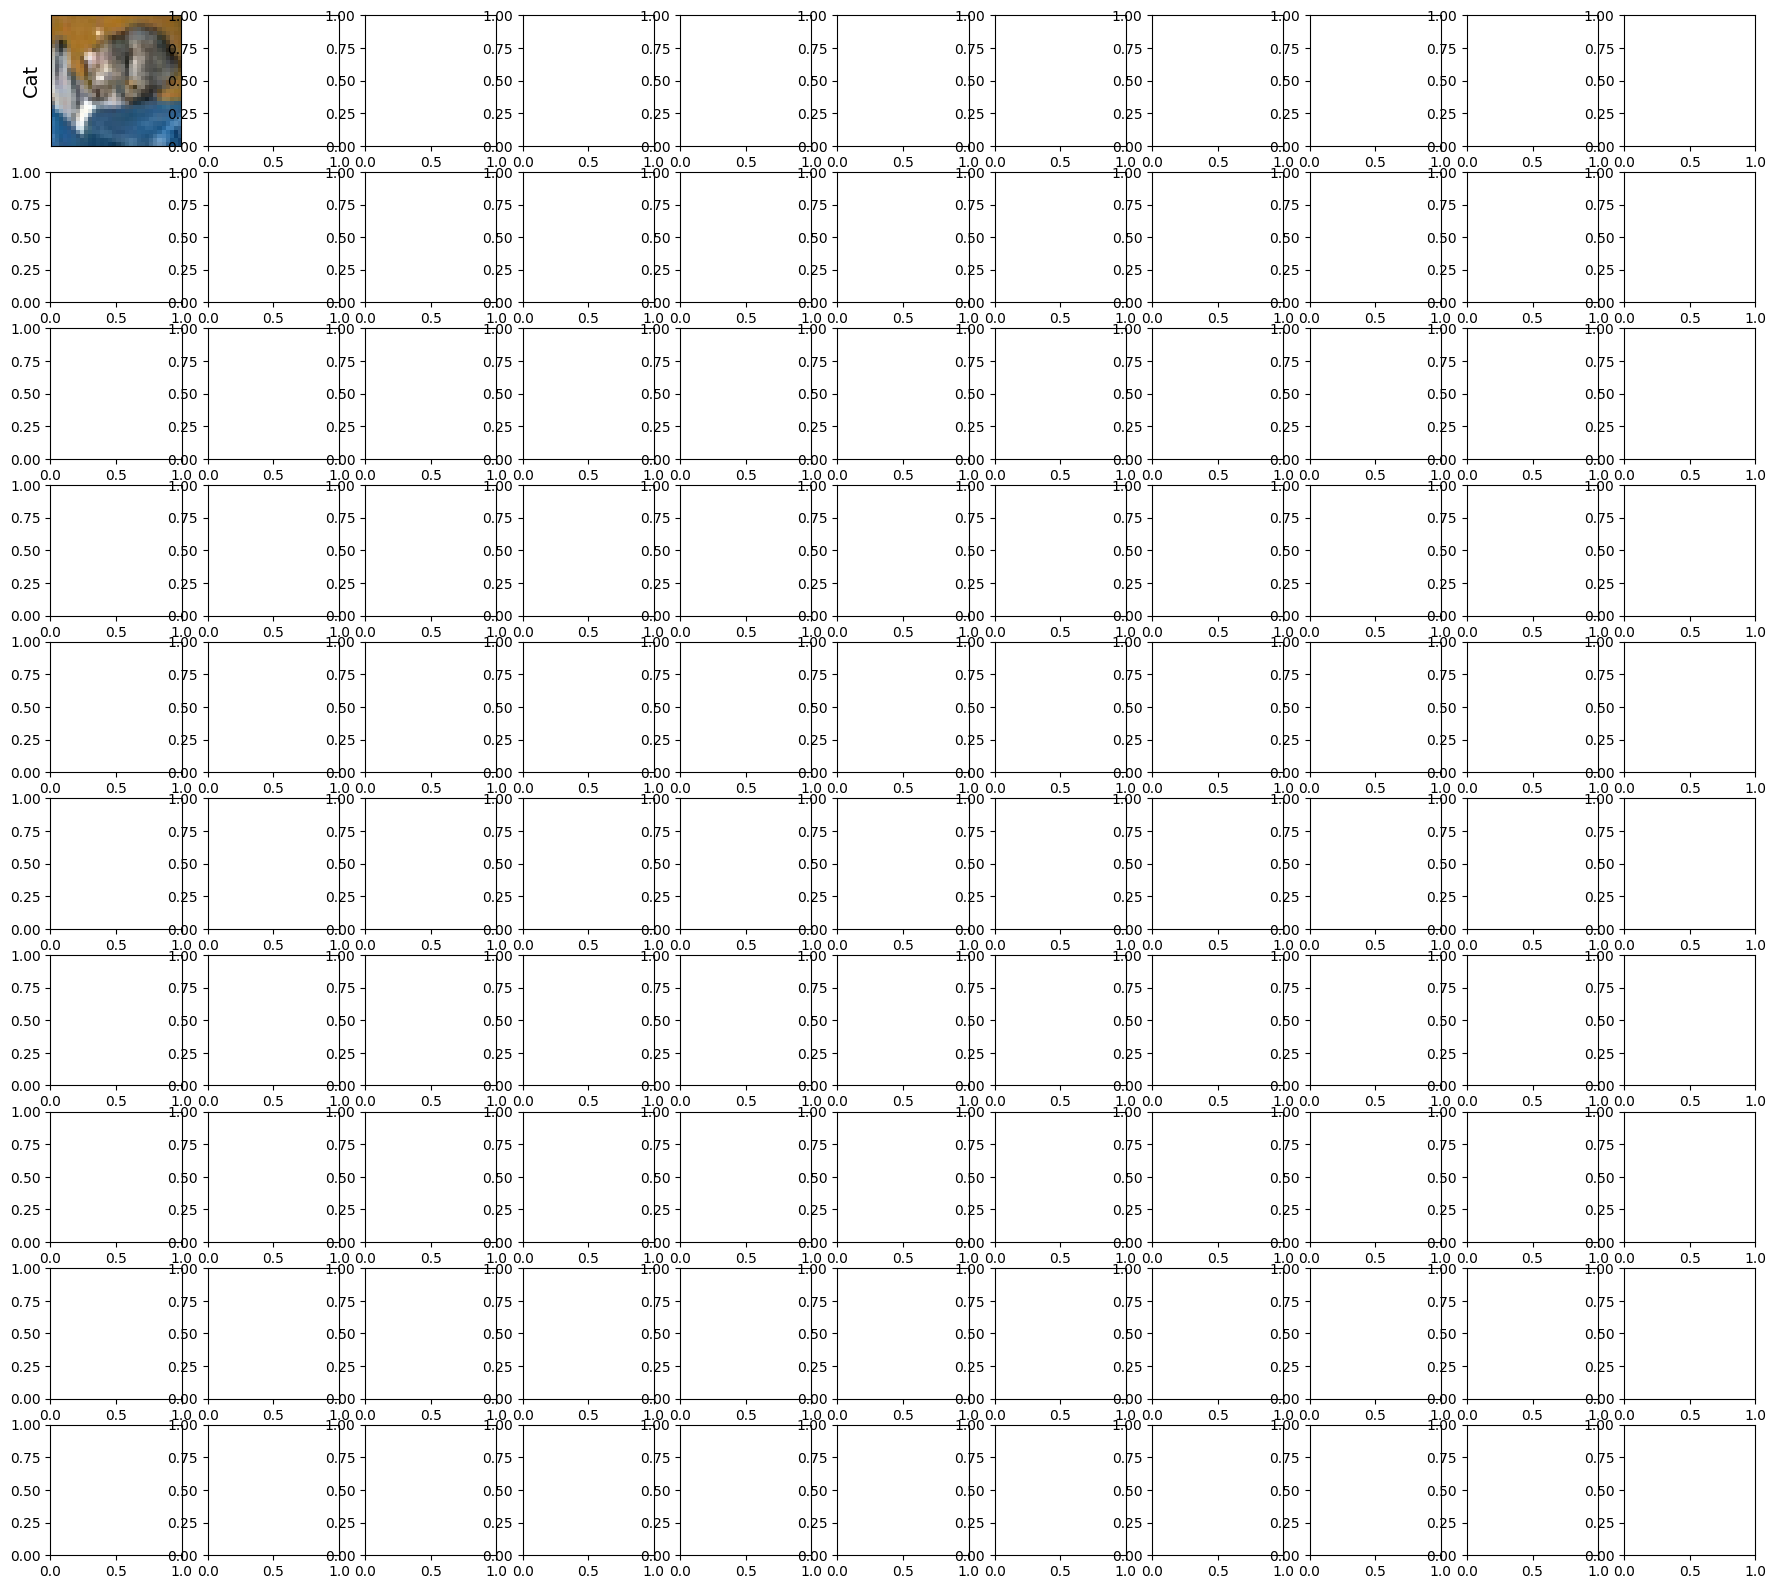

In [25]:
# # Select one image from each class
# # import torch
# # foo = torch.tensor([1,2,3])
# # foo = foo.to('cuda')
# # del fastshap
# # import gc

# # gc.collect()

# # torch.cuda.empty_cache()

# dset = val_set
# samples = np.array(dset.data)
# targets = np.array(dset.targets)
# num_classes = targets.max() + 1
# inds_lists = [np.where(targets == cat)[0] for cat in range(num_classes)]
# inds = [np.random.choice(cat_inds) for cat_inds in inds_lists]
# x, y = zip(*list(dset[i] for i in range(10)))
# x = torch.stack(x)

# # # Get explanations
# # values = torch.tensor(fastshap.shap_values(x.to(device)))
# # print(values.shape)
# # sorted_val = []
# # sorted_masks = []
# # for i in range(len(values)):
# #     sorted_val.append(values[i][i].flatten())
# #     sorted_val[i] = sorted(sorted_val[i], reverse=True)
# #     temp_coord = []
# #     for j in range(len(sorted_val[i])):
# #         mask = (values[i][i] == sorted_val[i][j])
# #         #print(mask)
# #         temp_coord.append(mask)
# #     sorted_masks.append(temp_coord)
# #     print(len(sorted_val))

# # eval_x = x
# # print(eval_x.shape)
# # top1_accuracies = []
# # for i in range(len(sorted_val[i])):
# #     for j in range(len(sorted_val)):
# #         mask = sorted_masks[j][0]
# #         print(mask)
# #         downsampled_tensor = F.interpolate(eval_x, (16, 16), mode='bilinear', align_corners=False)
# #         downsampled_tensor[j,:,mask] = 100
# #         eval_x = F.interpolate(downsampled_tensor, (32, 32), mode='bilinear', align_corners=False)

# import torch
# import torch.nn.functional as F

# # Assuming values is your SHAP values tensor with shape (batch_size, num_classes, num_features, height, width)
# #values = torch.tensor(fastshap.shap_values(x.to(device)))
# values_val = torch.tensor(fastshap.shap_values(x.to(device)))
# print("Shape of SHAP values tensor:", values_val.shape)

# calculate_exclusion(values_val, x, y)
# #calculate_inclusion(values_val, x, y)




# # basically get the classification accuracy of the imputer model whenever as you remove the top included pixel features and map this
# # do this for all the images
# # we have the way to get top pixel imp values at the top



# # Get predictions
# pred = imputer(
#     x.to(device),
#     torch.ones(num_classes, imputer.num_players, device=device)
# ).softmax(dim=1).cpu().data.numpy()

# fig, axarr = plt.subplots(num_classes, num_classes + 1, figsize=(22, 20))

# for row in range(num_classes):
#     # Image
#     classes = ['Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
#     mean = np.array([0.4914, 0.4822, 0.4465])[:, np.newaxis, np.newaxis]
#     std = np.array([0.2023, 0.1994, 0.2010])[:, np.newaxis, np.newaxis]
#     im = x[row].numpy() * std + mean
#     im = im.transpose(1, 2, 0).astype(float)
#     im = np.clip(im, a_min=0, a_max=1)
#     axarr[row, 0].imshow(im, vmin=0, vmax=1)
#     axarr[row, 0].set_xticks([])
#     axarr[row, 0].set_yticks([])
#     axarr[row, 0].set_ylabel('{}'.format(classes[y[row]]), fontsize=14)
    
#     # Explanations
#     m = np.abs(values[row]).max()
#     for col in range(num_classes):
#         axarr[row, col + 1].imshow(values[row, col], cmap='seismic', vmin=-m, vmax=m)
#         axarr[row, col + 1].set_xticks([])
#         axarr[row, col + 1].set_yticks([])
#         if col == y[row]:
#             axarr[row, col + 1].set_xlabel('{:.2f}'.format(pred[row, col]), fontsize=12, fontweight='bold')
#         else:
#             axarr[row, col + 1].set_xlabel('{:.2f}'.format(pred[row, col]), fontsize=12)
        
#         # Class labels
#         if row == 0:
#             axarr[row, col + 1].set_title('{}'.format(classes[y[col]]), fontsize=14)

# plt.tight_layout()
# plt.show()

# del values_val

In [12]:
num_shadow = 3
train_set = dsets.CIFAR10('../', train=True, download=True, transform=transform_train)
# random_indices = np.random.default_rng(seed=None).permutation(len(train_set))
random_indices = torch.randperm(len(train_set))
selected_i = random_indices[:30000]
n_selected_i = random_indices[30000:]
shadow_set = torch.utils.data.Subset(train_set, selected_i)
target_set = torch.utils.data.Subset(train_set, n_selected_i)

explainer4 = UNet(n_classes=10, num_down=2, num_up=1, num_convs=3).to(device)
fastshap_target_model = FastSHAP(explainer4, imputer, link=nn.LogSoftmax(dim=1))

fastshap_target_set = DatasetInputOnly(target_set)
fastshap_val = DatasetInputOnly(val_set)

torch.save(target_set, 'target_set.pt')
torch.save(val_set, 'val_set.pt')

fastshap_target_model.train(
    fastshap_target_set,
    fastshap_val,
    batch_size=128,
    num_samples=2,
    max_epochs=200,
    eff_lambda=1e-2,
    validation_samples=1,
    lookback=10,
    bar=True,
    verbose=True)

explainer4.cpu()
torch.save(explainer4, 'cifar target.pt')
explainer4.to(device)

Files already downloaded and verified


Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 1 -----
Val loss = 16528.095703

New best epoch, loss = 16528.095703



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 2 -----
Val loss = 16005.186523

New best epoch, loss = 16005.186523



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 3 -----
Val loss = 13630.234375

New best epoch, loss = 13630.234375



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 4 -----
Val loss = 13251.069336

New best epoch, loss = 13251.069336



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 5 -----
Val loss = 13073.994141

New best epoch, loss = 13073.994141



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 6 -----
Val loss = 11920.543945

New best epoch, loss = 11920.543945



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 7 -----
Val loss = 11719.514648

New best epoch, loss = 11719.514648



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 8 -----
Val loss = 10933.811523

New best epoch, loss = 10933.811523



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 9 -----
Val loss = 10779.375000

New best epoch, loss = 10779.375000



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 10 -----
Val loss = 11094.708008



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 11 -----
Val loss = 10238.112305

New best epoch, loss = 10238.112305



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 12 -----
Val loss = 11600.353516



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 13 -----
Val loss = 10241.696289



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 14 -----
Val loss = 9875.019531

New best epoch, loss = 9875.019531



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 15 -----
Val loss = 9314.216797

New best epoch, loss = 9314.216797



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 16 -----
Val loss = 9433.908203



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 17 -----
Val loss = 10526.213867



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 18 -----
Val loss = 8631.299805

New best epoch, loss = 8631.299805



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 19 -----
Val loss = 8738.657227



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 20 -----
Val loss = 8958.219727



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 21 -----
Val loss = 9145.792969



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 22 -----
Val loss = 8538.432617

New best epoch, loss = 8538.432617



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 23 -----
Val loss = 7906.793457

New best epoch, loss = 7906.793457



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 24 -----
Val loss = 8081.838379



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 25 -----
Val loss = 8570.916016



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 26 -----
Val loss = 8328.707031



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 27 -----
Val loss = 7870.573242

New best epoch, loss = 7870.573242



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 28 -----
Val loss = 8069.353027



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 29 -----
Val loss = 8378.893555



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 30 -----
Val loss = 8222.011719



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 31 -----
Val loss = 7849.281738

New best epoch, loss = 7849.281738



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 32 -----
Val loss = 7881.384277



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 33 -----
Val loss = 7581.859375

New best epoch, loss = 7581.859375



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 34 -----
Val loss = 8428.210938



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 35 -----
Val loss = 7440.789062

New best epoch, loss = 7440.789062



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 36 -----
Val loss = 7279.010254

New best epoch, loss = 7279.010254



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 37 -----
Val loss = 7728.597656



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 38 -----
Val loss = 7103.401367

New best epoch, loss = 7103.401367



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 39 -----
Val loss = 7808.099121



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 40 -----
Val loss = 7118.188965



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 41 -----
Val loss = 7115.071289



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 42 -----
Val loss = 7425.335938



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 43 -----
Val loss = 7093.561035

New best epoch, loss = 7093.561035



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 44 -----
Val loss = 7226.272949



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 45 -----
Val loss = 7003.376953

New best epoch, loss = 7003.376953



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 46 -----
Val loss = 7106.142090



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 47 -----
Val loss = 6854.276855

New best epoch, loss = 6854.276855



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 48 -----
Val loss = 6897.312012



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 49 -----
Val loss = 6809.026855

New best epoch, loss = 6809.026855



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 50 -----
Val loss = 6755.001953

New best epoch, loss = 6755.001953



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 51 -----
Val loss = 6814.339844



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 52 -----
Val loss = 6760.889648



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 53 -----
Val loss = 6942.493164



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 54 -----
Val loss = 6808.891602



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 55 -----
Val loss = 7008.683105



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 56 -----
Val loss = 6350.937012

New best epoch, loss = 6350.937012



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 57 -----
Val loss = 6730.789062



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 58 -----
Val loss = 6916.390625



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 59 -----
Val loss = 6958.524414



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 60 -----
Val loss = 6872.274902



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 61 -----
Val loss = 6984.843750



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 62 -----
Val loss = 6301.812012

New best epoch, loss = 6301.812012



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 63 -----
Val loss = 6461.617676



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 64 -----
Val loss = 6734.847168



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 65 -----
Val loss = 6662.687500



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 66 -----
Val loss = 6383.713867



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 67 -----
Val loss = 6315.923340



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 68 -----
Val loss = 6539.128418

Epoch 00068: reducing learning rate of group 0 to 1.0000e-04.


Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 69 -----
Val loss = 5869.814941

New best epoch, loss = 5869.814941



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 70 -----
Val loss = 6020.026855



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 71 -----
Val loss = 6017.165039



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 72 -----
Val loss = 5974.563965



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 73 -----
Val loss = 5989.090820



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 74 -----
Val loss = 5973.987305



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 75 -----
Val loss = 5950.248535

Epoch 00075: reducing learning rate of group 0 to 5.0000e-05.


Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 76 -----
Val loss = 5718.832031

New best epoch, loss = 5718.832031



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 77 -----
Val loss = 5677.377930

New best epoch, loss = 5677.377930



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 78 -----
Val loss = 5808.136719



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 79 -----
Val loss = 5708.162598



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 80 -----
Val loss = 5739.489746



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 81 -----
Val loss = 5685.845703



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 82 -----
Val loss = 5663.837402

New best epoch, loss = 5663.837402



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 83 -----
Val loss = 5647.408691

New best epoch, loss = 5647.408691



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 84 -----
Val loss = 5678.587891



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 85 -----
Val loss = 5704.680176



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 86 -----
Val loss = 5677.126953



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 87 -----
Val loss = 5812.794922



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 88 -----
Val loss = 5646.765625

New best epoch, loss = 5646.765625



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 89 -----
Val loss = 5658.797363



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 90 -----
Val loss = 5608.635254

New best epoch, loss = 5608.635254



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 91 -----
Val loss = 5735.008789



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 92 -----
Val loss = 5688.287598



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 93 -----
Val loss = 5734.790039



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 94 -----
Val loss = 5725.982910



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 95 -----
Val loss = 5583.104980

New best epoch, loss = 5583.104980



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 96 -----
Val loss = 5732.958496



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 97 -----
Val loss = 5661.181152



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 98 -----
Val loss = 5740.899414



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 99 -----
Val loss = 5649.682129



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 100 -----
Val loss = 5731.652344



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 101 -----
Val loss = 5644.795410

Epoch 00101: reducing learning rate of group 0 to 2.5000e-05.


Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 102 -----
Val loss = 5573.230957

New best epoch, loss = 5573.230957



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 103 -----
Val loss = 5560.898438

New best epoch, loss = 5560.898438



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 104 -----
Val loss = 5547.451660

New best epoch, loss = 5547.451660



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 105 -----
Val loss = 5486.715332

New best epoch, loss = 5486.715332



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 106 -----
Val loss = 5552.191895



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 107 -----
Val loss = 5522.179199



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 108 -----
Val loss = 5490.369141



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 109 -----
Val loss = 5561.854980



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 110 -----
Val loss = 5586.103027



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 111 -----
Val loss = 5565.144043

Epoch 00111: reducing learning rate of group 0 to 1.2500e-05.


Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 112 -----
Val loss = 5473.384766

New best epoch, loss = 5473.384766



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 113 -----
Val loss = 5494.989746



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 114 -----
Val loss = 5475.106934



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 115 -----
Val loss = 5460.800781

New best epoch, loss = 5460.800781



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 116 -----
Val loss = 5469.012207



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 117 -----
Val loss = 5473.909668



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 118 -----
Val loss = 5488.790527



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 119 -----
Val loss = 5503.873047



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 120 -----
Val loss = 5496.676270



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 121 -----
Val loss = 5476.970703

Epoch 00121: reducing learning rate of group 0 to 1.0000e-05.


Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 122 -----
Val loss = 5445.901367

New best epoch, loss = 5445.901367



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 123 -----
Val loss = 5467.409668



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 124 -----
Val loss = 5478.405273



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 125 -----
Val loss = 5434.414062

New best epoch, loss = 5434.414062



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 126 -----
Val loss = 5433.235840

New best epoch, loss = 5433.235840



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 127 -----
Val loss = 5439.095215



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 128 -----
Val loss = 5458.826172



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 129 -----
Val loss = 5465.678711



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 130 -----
Val loss = 5461.429688



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 131 -----
Val loss = 5435.442383



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 132 -----
Val loss = 5432.881836

New best epoch, loss = 5432.881836



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 133 -----
Val loss = 5448.302246



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 134 -----
Val loss = 5421.219727

New best epoch, loss = 5421.219727



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 135 -----
Val loss = 5434.463867



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 136 -----
Val loss = 5433.412109



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 137 -----
Val loss = 5442.669434



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 138 -----
Val loss = 5458.755859



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 139 -----
Val loss = 5450.459473



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 140 -----
Val loss = 5415.567871

New best epoch, loss = 5415.567871



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 141 -----
Val loss = 5442.740723



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 142 -----
Val loss = 5473.896973



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 143 -----
Val loss = 5421.229004



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 144 -----
Val loss = 5441.343262



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 145 -----
Val loss = 5422.894043



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 146 -----
Val loss = 5483.573242



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 147 -----
Val loss = 5421.659668



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 148 -----
Val loss = 5448.932617



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 149 -----
Val loss = 5433.537109



Training epoch:   0%|          | 0/156 [00:00<?, ?it/s]

----- Epoch = 150 -----
Val loss = 5463.065430

Stopping early at epoch = 149


UNet(
  (inc): MultiConv(
    (multi_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
    )
  )
  (down_layers): ModuleList(
    (0): Down(
      (maxpool_conv): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): MultiConv(
          (multi_conv): Sequential(
            (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(12

In [13]:
#del explainer4
random_indices = torch.randperm(len(shadow_set))
first_i = random_indices[:10000]
second_i = random_indices[10000:20000]
third_i = random_indices[20000:]
shadow_set1 = torch.utils.data.Subset(shadow_set, first_i)
shadow_set2 = torch.utils.data.Subset(shadow_set, second_i)
shadow_set3 = torch.utils.data.Subset(shadow_set, third_i)

# Set up explainer model
explainer1 = UNet(n_classes=10, num_down=2, num_up=1, num_convs=3).to(device)
explainer2 = UNet(n_classes=10, num_down=2, num_up=1, num_convs=3).to(device)
explainer3 = UNet(n_classes=10, num_down=2, num_up=1, num_convs=3).to(device)

# Set up FastSHAP object
fastshap_shadow1 = FastSHAP(explainer1, imputer, link=nn.LogSoftmax(dim=1))
fastshap_shadow2 = FastSHAP(explainer2, imputer, link=nn.LogSoftmax(dim=1))
fastshap_shadow3 = FastSHAP(explainer3, imputer, link=nn.LogSoftmax(dim=1))


# Set up datasets
# the train and val set are just the CIFAR dataset
fastshap_train1 = DatasetInputOnly(shadow_set1)
fastshap_train2 = DatasetInputOnly(shadow_set2)
fastshap_train3 = DatasetInputOnly(shadow_set3)
fastshap_val = DatasetInputOnly(val_set)

torch.save(shadow_set1, "shadow_set1.pt")
torch.save(shadow_set2, "shadow_set2.pt")
torch.save(shadow_set3, "shadow_set3.pt")

# Train
fastshap_shadow1.train(
    fastshap_train1,
    fastshap_val,
    batch_size=128,
    num_samples=2,
    max_epochs=200,
    eff_lambda=1e-2,
    validation_samples=1,
    lookback=10,
    bar=True,
    verbose=True)

fastshap_shadow2.train(
    fastshap_train2,
    fastshap_val,
    batch_size=128,
    num_samples=2,
    max_epochs=200,
    eff_lambda=1e-2,
    validation_samples=1,
    lookback=10,
    bar=True,
    verbose=True)

fastshap_shadow3.train(
    fastshap_train3,
    fastshap_val,
    batch_size=128,
    num_samples=2,
    max_epochs=200,
    eff_lambda=1e-2,
    validation_samples=1,
    lookback=10,
    bar=True,
    verbose=True)



# Save explainer
explainer1.cpu()
torch.save(explainer1, 'cifar missingness explainer1.pt')
explainer1.to(device)

explainer2.cpu()
torch.save(explainer2, 'cifar missingness explainer2.pt')
explainer2.to(device)

explainer3.cpu()
torch.save(explainer3, 'cifar missingness explainer3.pt')
explainer3.to(device)



# for i in range(num_shadow):
#     # Set up explainer model
#     explainer = UNet(n_classes=10, num_down=2, num_up=1, num_convs=3).to(device)

#     # Set up FastSHAP object
#     fastshap_shadow = FastSHAP(explainer, imputer, link=nn.LogSoftmax(dim=1))

#     # Set up datasets
#     # the train and val set are just the CIFAR dataset
#     fastshap_train = DatasetInputOnly(train_set)
#     fastshap_val = DatasetInputOnly(val_set)

#     # Train
#     fastshap.train(
#         fastshap_train,
#         fastshap_val,
#         batch_size=128,
#         num_samples=2,
#         max_epochs=200,
#         eff_lambda=1e-2,
#         validation_samples=1,
#         lookback=10,
#         bar=True,
#         verbose=True)
    
#     # Save explainer
#     explainer.cpu()
#     torch.save(explainer, 'cifar missingness explainer.pt')
#     explainer.to(device)

Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 1 -----
Val loss = 15986.863281

New best epoch, loss = 15986.863281



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 2 -----
Val loss = 15015.531250

New best epoch, loss = 15015.531250



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 3 -----
Val loss = 14289.069336

New best epoch, loss = 14289.069336



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 4 -----
Val loss = 13663.774414

New best epoch, loss = 13663.774414



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 5 -----
Val loss = 14123.333008



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 6 -----
Val loss = 14194.021484



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 7 -----
Val loss = 12190.368164

New best epoch, loss = 12190.368164



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 8 -----
Val loss = 11996.617188

New best epoch, loss = 11996.617188



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 9 -----
Val loss = 13117.927734



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 10 -----
Val loss = 12680.848633



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 11 -----
Val loss = 11625.630859

New best epoch, loss = 11625.630859



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 12 -----
Val loss = 11347.672852

New best epoch, loss = 11347.672852



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 13 -----
Val loss = 11545.107422



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 14 -----
Val loss = 11176.365234

New best epoch, loss = 11176.365234



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 15 -----
Val loss = 10867.440430

New best epoch, loss = 10867.440430



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 16 -----
Val loss = 11097.788086



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 17 -----
Val loss = 9823.286133

New best epoch, loss = 9823.286133



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 18 -----
Val loss = 11155.356445



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 19 -----
Val loss = 10102.625000



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 20 -----
Val loss = 9925.761719



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 21 -----
Val loss = 9880.173828



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 22 -----
Val loss = 9964.711914



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 23 -----
Val loss = 9257.600586

New best epoch, loss = 9257.600586



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 24 -----
Val loss = 10336.969727



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 25 -----
Val loss = 9563.012695



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 26 -----
Val loss = 9624.564453



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 27 -----
Val loss = 9189.423828

New best epoch, loss = 9189.423828



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 28 -----
Val loss = 9592.808594



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 29 -----
Val loss = 8756.470703

New best epoch, loss = 8756.470703



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 30 -----
Val loss = 9190.723633



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 31 -----
Val loss = 8913.016602



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 32 -----
Val loss = 8615.956055

New best epoch, loss = 8615.956055



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 33 -----
Val loss = 8606.566406

New best epoch, loss = 8606.566406



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 34 -----
Val loss = 9767.195312



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 35 -----
Val loss = 8873.864258



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 36 -----
Val loss = 8120.281738

New best epoch, loss = 8120.281738



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 37 -----
Val loss = 8914.262695



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 38 -----
Val loss = 8041.795410

New best epoch, loss = 8041.795410



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 39 -----
Val loss = 8485.394531



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 40 -----
Val loss = 8554.600586



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 41 -----
Val loss = 8287.897461



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 42 -----
Val loss = 8521.273438



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 43 -----
Val loss = 8096.465332



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 44 -----
Val loss = 8003.208008

New best epoch, loss = 8003.208008



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 45 -----
Val loss = 7882.830078

New best epoch, loss = 7882.830078



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 46 -----
Val loss = 8686.768555



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 47 -----
Val loss = 8197.527344



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 48 -----
Val loss = 7948.083008



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 49 -----
Val loss = 8071.436035



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 50 -----
Val loss = 8212.545898



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 51 -----
Val loss = 7747.915527

New best epoch, loss = 7747.915527



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 52 -----
Val loss = 7871.411621



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 53 -----
Val loss = 7962.546387



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 54 -----
Val loss = 8054.999023



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 55 -----
Val loss = 8186.018066



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 56 -----
Val loss = 8373.125000



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 57 -----
Val loss = 7716.376953

New best epoch, loss = 7716.376953



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 58 -----
Val loss = 7676.496094

New best epoch, loss = 7676.496094



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 59 -----
Val loss = 8430.322266



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 60 -----
Val loss = 7595.035156

New best epoch, loss = 7595.035156



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 61 -----
Val loss = 7382.927734

New best epoch, loss = 7382.927734



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 62 -----
Val loss = 7531.137207



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 63 -----
Val loss = 7866.968262



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 64 -----
Val loss = 7432.246582



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 65 -----
Val loss = 7695.089844



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 66 -----
Val loss = 7592.136230



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 67 -----
Val loss = 7293.564941

New best epoch, loss = 7293.564941



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 68 -----
Val loss = 7358.592773



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 69 -----
Val loss = 7242.958984

New best epoch, loss = 7242.958984



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 70 -----
Val loss = 7218.131836

New best epoch, loss = 7218.131836



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 71 -----
Val loss = 7435.482910



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 72 -----
Val loss = 7569.696289



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 73 -----
Val loss = 7437.889648



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 74 -----
Val loss = 7620.510742



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 75 -----
Val loss = 7547.849609



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 76 -----
Val loss = 7561.304199

Epoch 00076: reducing learning rate of group 0 to 1.0000e-04.


Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 77 -----
Val loss = 6647.262207

New best epoch, loss = 6647.262207



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 78 -----
Val loss = 6861.203613



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 79 -----
Val loss = 6815.641602



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 80 -----
Val loss = 6834.677246



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 81 -----
Val loss = 6690.645508



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 82 -----
Val loss = 6670.981445



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 83 -----
Val loss = 6608.563477

New best epoch, loss = 6608.563477



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 84 -----
Val loss = 6728.589844



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 85 -----
Val loss = 6659.456543



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 86 -----
Val loss = 6632.276367



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 87 -----
Val loss = 6648.697266



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 88 -----
Val loss = 6772.704102



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 89 -----
Val loss = 6565.815430

New best epoch, loss = 6565.815430



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 90 -----
Val loss = 6767.412109



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 91 -----
Val loss = 6783.478027



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 92 -----
Val loss = 7023.178711



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 93 -----
Val loss = 6604.086914



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 94 -----
Val loss = 6649.760742



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 95 -----
Val loss = 6706.023926

Epoch 00095: reducing learning rate of group 0 to 5.0000e-05.


Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 96 -----
Val loss = 6480.449707

New best epoch, loss = 6480.449707



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 97 -----
Val loss = 6402.960938

New best epoch, loss = 6402.960938



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 98 -----
Val loss = 6451.651855



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 99 -----
Val loss = 6380.784180

New best epoch, loss = 6380.784180



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 100 -----
Val loss = 6379.484375

New best epoch, loss = 6379.484375



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 101 -----
Val loss = 6555.365234



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 102 -----
Val loss = 6404.531738



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 103 -----
Val loss = 6436.520508



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 104 -----
Val loss = 6342.750488

New best epoch, loss = 6342.750488



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 105 -----
Val loss = 6475.274414



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 106 -----
Val loss = 6420.239258



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 107 -----
Val loss = 6439.548828



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 108 -----
Val loss = 6307.290527

New best epoch, loss = 6307.290527



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 109 -----
Val loss = 6524.372559



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 110 -----
Val loss = 6484.791016



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 111 -----
Val loss = 6473.447266



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 112 -----
Val loss = 6372.592773



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 113 -----
Val loss = 6383.124023



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 114 -----
Val loss = 6450.568359

Epoch 00114: reducing learning rate of group 0 to 2.5000e-05.


Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 115 -----
Val loss = 6330.814453



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 116 -----
Val loss = 6260.468750

New best epoch, loss = 6260.468750



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 117 -----
Val loss = 6257.881836

New best epoch, loss = 6257.881836



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 118 -----
Val loss = 6219.833984

New best epoch, loss = 6219.833984



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 119 -----
Val loss = 6240.288086



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 120 -----
Val loss = 6241.164551



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 121 -----
Val loss = 6239.787598



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 122 -----
Val loss = 6221.932617



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 123 -----
Val loss = 6231.435547



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 124 -----
Val loss = 6250.422363

Epoch 00124: reducing learning rate of group 0 to 1.2500e-05.


Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 125 -----
Val loss = 6187.078125

New best epoch, loss = 6187.078125



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 126 -----
Val loss = 6166.338379

New best epoch, loss = 6166.338379



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 127 -----
Val loss = 6162.524902

New best epoch, loss = 6162.524902



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 128 -----
Val loss = 6165.570312



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 129 -----
Val loss = 6168.322754



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 130 -----
Val loss = 6165.645508



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 131 -----
Val loss = 6173.418945



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 132 -----
Val loss = 6141.032715

New best epoch, loss = 6141.032715



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 133 -----
Val loss = 6218.746094



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 134 -----
Val loss = 6163.529785



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 135 -----
Val loss = 6155.913086



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 136 -----
Val loss = 6131.353516

New best epoch, loss = 6131.353516



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 137 -----
Val loss = 6135.465820



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 138 -----
Val loss = 6149.104492



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 139 -----
Val loss = 6182.647949



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 140 -----
Val loss = 6175.695312



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 141 -----
Val loss = 6127.256348

New best epoch, loss = 6127.256348



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 142 -----
Val loss = 6194.971191



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 143 -----
Val loss = 6168.897461



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 144 -----
Val loss = 6163.595215



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 145 -----
Val loss = 6154.026367



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 146 -----
Val loss = 6157.896973



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 147 -----
Val loss = 6178.422852

Epoch 00147: reducing learning rate of group 0 to 1.0000e-05.


Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 148 -----
Val loss = 6150.116699



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 149 -----
Val loss = 6160.272461



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 150 -----
Val loss = 6186.837891



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 151 -----
Val loss = 6156.851074

Stopping early at epoch = 150


Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 1 -----
Val loss = 16386.867188

New best epoch, loss = 16386.867188



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 2 -----
Val loss = 14841.844727

New best epoch, loss = 14841.844727



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 3 -----
Val loss = 13925.239258

New best epoch, loss = 13925.239258



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 4 -----
Val loss = 13905.476562

New best epoch, loss = 13905.476562



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 5 -----
Val loss = 13102.512695

New best epoch, loss = 13102.512695



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 6 -----
Val loss = 12956.130859

New best epoch, loss = 12956.130859



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 7 -----
Val loss = 12562.173828

New best epoch, loss = 12562.173828



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 8 -----
Val loss = 13547.374023



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 9 -----
Val loss = 12078.733398

New best epoch, loss = 12078.733398



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 10 -----
Val loss = 11366.749023

New best epoch, loss = 11366.749023



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 11 -----
Val loss = 12461.509766



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 12 -----
Val loss = 12243.458984



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 13 -----
Val loss = 10881.412109

New best epoch, loss = 10881.412109



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 14 -----
Val loss = 12938.994141



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 15 -----
Val loss = 10239.437500

New best epoch, loss = 10239.437500



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 16 -----
Val loss = 10366.455078



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 17 -----
Val loss = 9934.038086

New best epoch, loss = 9934.038086



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 18 -----
Val loss = 10475.127930



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 19 -----
Val loss = 11103.429688



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 20 -----
Val loss = 11046.623047



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 21 -----
Val loss = 9947.706055



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 22 -----
Val loss = 9445.820312

New best epoch, loss = 9445.820312



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 23 -----
Val loss = 9619.222656



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 24 -----
Val loss = 10036.997070



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 25 -----
Val loss = 9893.449219



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 26 -----
Val loss = 10617.108398



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 27 -----
Val loss = 8891.956055

New best epoch, loss = 8891.956055



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 28 -----
Val loss = 9581.355469



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 29 -----
Val loss = 8915.203125



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 30 -----
Val loss = 8850.592773

New best epoch, loss = 8850.592773



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 31 -----
Val loss = 9380.833984



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 32 -----
Val loss = 8477.794922

New best epoch, loss = 8477.794922



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 33 -----
Val loss = 10400.749023



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 34 -----
Val loss = 8266.977539

New best epoch, loss = 8266.977539



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 35 -----
Val loss = 8456.193359



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 36 -----
Val loss = 8451.449219



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 37 -----
Val loss = 8940.871094



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 38 -----
Val loss = 8358.876953



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 39 -----
Val loss = 8379.505859



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 40 -----
Val loss = 8345.076172

Epoch 00040: reducing learning rate of group 0 to 1.0000e-04.


Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 41 -----
Val loss = 7608.661133

New best epoch, loss = 7608.661133



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 42 -----
Val loss = 7776.334961



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 43 -----
Val loss = 7730.437500



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 44 -----
Val loss = 7738.157227



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 45 -----
Val loss = 7823.316406



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 46 -----
Val loss = 7696.539062



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 47 -----
Val loss = 7591.021973

New best epoch, loss = 7591.021973



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 48 -----
Val loss = 7533.017578

New best epoch, loss = 7533.017578



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 49 -----
Val loss = 7675.288086



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 50 -----
Val loss = 7811.890137



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 51 -----
Val loss = 7496.389160

New best epoch, loss = 7496.389160



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 52 -----
Val loss = 7672.950195



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 53 -----
Val loss = 7568.417480



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 54 -----
Val loss = 7914.732910



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 55 -----
Val loss = 7538.836914



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 56 -----
Val loss = 7810.052246



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 57 -----
Val loss = 7636.908203

Epoch 00057: reducing learning rate of group 0 to 5.0000e-05.


Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 58 -----
Val loss = 7357.164062

New best epoch, loss = 7357.164062



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 59 -----
Val loss = 7138.847656

New best epoch, loss = 7138.847656



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 60 -----
Val loss = 7258.627441



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 61 -----
Val loss = 7361.628418



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 62 -----
Val loss = 7354.806641



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 63 -----
Val loss = 7080.026367

New best epoch, loss = 7080.026367



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 64 -----
Val loss = 7209.095215



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 65 -----
Val loss = 7194.331543



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 66 -----
Val loss = 7163.375488



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 67 -----
Val loss = 7294.049316



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 68 -----
Val loss = 7227.670410



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 69 -----
Val loss = 7116.510742

Epoch 00069: reducing learning rate of group 0 to 2.5000e-05.


Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 70 -----
Val loss = 6972.286133

New best epoch, loss = 6972.286133



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 71 -----
Val loss = 6916.561523

New best epoch, loss = 6916.561523



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 72 -----
Val loss = 7043.115723



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 73 -----
Val loss = 6982.874512



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 74 -----
Val loss = 6944.355957



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 75 -----
Val loss = 6992.568359



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 76 -----
Val loss = 7105.156250



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 77 -----
Val loss = 6876.725586

New best epoch, loss = 6876.725586



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 78 -----
Val loss = 6965.931641



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 79 -----
Val loss = 7006.357422



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 80 -----
Val loss = 7015.446289



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 81 -----
Val loss = 6949.141602



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 82 -----
Val loss = 6949.767090



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 83 -----
Val loss = 6951.782715

Epoch 00083: reducing learning rate of group 0 to 1.2500e-05.


Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 84 -----
Val loss = 6832.235840

New best epoch, loss = 6832.235840



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 85 -----
Val loss = 6871.518066



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 86 -----
Val loss = 6849.894043



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 87 -----
Val loss = 6864.687012



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 88 -----
Val loss = 6850.062988



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 89 -----
Val loss = 6829.302734

New best epoch, loss = 6829.302734



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 90 -----
Val loss = 6829.137207

New best epoch, loss = 6829.137207



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 91 -----
Val loss = 6841.739746



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 92 -----
Val loss = 6898.736816



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 93 -----
Val loss = 6934.379883



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 94 -----
Val loss = 6874.805176



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 95 -----
Val loss = 6827.894531

New best epoch, loss = 6827.894531



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 96 -----
Val loss = 6805.233398

New best epoch, loss = 6805.233398



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 97 -----
Val loss = 6783.072754

New best epoch, loss = 6783.072754



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 98 -----
Val loss = 6819.951660



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 99 -----
Val loss = 6844.626953



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 100 -----
Val loss = 6820.348633



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 101 -----
Val loss = 6762.928223

New best epoch, loss = 6762.928223



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 102 -----
Val loss = 6847.186035



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 103 -----
Val loss = 6908.884766



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 104 -----
Val loss = 6812.126953



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 105 -----
Val loss = 6838.446777



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 106 -----
Val loss = 6769.423828



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 107 -----
Val loss = 6854.439453

Epoch 00107: reducing learning rate of group 0 to 1.0000e-05.


Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 108 -----
Val loss = 6795.008301



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 109 -----
Val loss = 6764.254883



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 110 -----
Val loss = 6752.526367

New best epoch, loss = 6752.526367



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 111 -----
Val loss = 6735.087402

New best epoch, loss = 6735.087402



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 112 -----
Val loss = 6803.154785



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 113 -----
Val loss = 6764.546875



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 114 -----
Val loss = 6840.506836



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 115 -----
Val loss = 6801.637695



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 116 -----
Val loss = 6800.806152



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 117 -----
Val loss = 6762.069336



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 118 -----
Val loss = 6829.594727



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 119 -----
Val loss = 6753.041504



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 120 -----
Val loss = 6779.958496



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 121 -----
Val loss = 6756.572754

Stopping early at epoch = 120


Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 1 -----
Val loss = 16642.304688

New best epoch, loss = 16642.304688



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 2 -----
Val loss = 14803.180664

New best epoch, loss = 14803.180664



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 3 -----
Val loss = 14117.321289

New best epoch, loss = 14117.321289



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 4 -----
Val loss = 13315.160156

New best epoch, loss = 13315.160156



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 5 -----
Val loss = 12981.197266

New best epoch, loss = 12981.197266



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 6 -----
Val loss = 12587.919922

New best epoch, loss = 12587.919922



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 7 -----
Val loss = 12507.922852

New best epoch, loss = 12507.922852



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 8 -----
Val loss = 12707.947266



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 9 -----
Val loss = 11639.593750

New best epoch, loss = 11639.593750



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 10 -----
Val loss = 11874.936523



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 11 -----
Val loss = 12001.593750



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 12 -----
Val loss = 10914.019531

New best epoch, loss = 10914.019531



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 13 -----
Val loss = 11463.348633



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 14 -----
Val loss = 12072.591797



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 15 -----
Val loss = 10856.623047

New best epoch, loss = 10856.623047



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 16 -----
Val loss = 11787.602539



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 17 -----
Val loss = 11184.375977



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 18 -----
Val loss = 9984.637695

New best epoch, loss = 9984.637695



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 19 -----
Val loss = 9880.098633

New best epoch, loss = 9880.098633



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 20 -----
Val loss = 10763.646484



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 21 -----
Val loss = 9413.984375

New best epoch, loss = 9413.984375



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 22 -----
Val loss = 9634.148438



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 23 -----
Val loss = 9940.284180



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 24 -----
Val loss = 9609.638672



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 25 -----
Val loss = 10150.495117



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 26 -----
Val loss = 9624.998047



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 27 -----
Val loss = 9411.037109

New best epoch, loss = 9411.037109



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 28 -----
Val loss = 8969.975586

New best epoch, loss = 8969.975586



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 29 -----
Val loss = 8767.767578

New best epoch, loss = 8767.767578



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 30 -----
Val loss = 9195.439453



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 31 -----
Val loss = 9457.374023



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 32 -----
Val loss = 8647.486328

New best epoch, loss = 8647.486328



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 33 -----
Val loss = 8418.109375

New best epoch, loss = 8418.109375



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 34 -----
Val loss = 8792.590820



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 35 -----
Val loss = 9825.255859



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 36 -----
Val loss = 8665.562500



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 37 -----
Val loss = 8214.819336

New best epoch, loss = 8214.819336



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 38 -----
Val loss = 8751.167969



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 39 -----
Val loss = 8510.725586



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 40 -----
Val loss = 8959.253906



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 41 -----
Val loss = 8014.717285

New best epoch, loss = 8014.717285



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 42 -----
Val loss = 8728.501953



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 43 -----
Val loss = 8521.414062



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 44 -----
Val loss = 8203.971680



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 45 -----
Val loss = 8598.670898



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 46 -----
Val loss = 8287.138672



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 47 -----
Val loss = 8454.973633

Epoch 00047: reducing learning rate of group 0 to 1.0000e-04.


Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 48 -----
Val loss = 7453.758301

New best epoch, loss = 7453.758301



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 49 -----
Val loss = 7609.413574



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 50 -----
Val loss = 7515.738281



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 51 -----
Val loss = 7557.829102



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 52 -----
Val loss = 7515.500000



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 53 -----
Val loss = 7536.468750



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 54 -----
Val loss = 7520.137695

Epoch 00054: reducing learning rate of group 0 to 5.0000e-05.


Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 55 -----
Val loss = 7267.301758

New best epoch, loss = 7267.301758



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 56 -----
Val loss = 7004.744629

New best epoch, loss = 7004.744629



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 57 -----
Val loss = 7133.935547



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 58 -----
Val loss = 7067.265625



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 59 -----
Val loss = 6990.183594

New best epoch, loss = 6990.183594



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 60 -----
Val loss = 7131.618652



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 61 -----
Val loss = 7046.985352



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 62 -----
Val loss = 7111.598145



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 63 -----
Val loss = 7007.472168



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 64 -----
Val loss = 7173.629395



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 65 -----
Val loss = 6974.727051

New best epoch, loss = 6974.727051



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 66 -----
Val loss = 7103.445801



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 67 -----
Val loss = 7012.924805



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 68 -----
Val loss = 7082.949707



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 69 -----
Val loss = 7026.480469



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 70 -----
Val loss = 7027.818848



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 71 -----
Val loss = 7049.825195

Epoch 00071: reducing learning rate of group 0 to 2.5000e-05.


Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 72 -----
Val loss = 6855.813965

New best epoch, loss = 6855.813965



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 73 -----
Val loss = 6905.527832



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 74 -----
Val loss = 6851.937012

New best epoch, loss = 6851.937012



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 75 -----
Val loss = 6852.823730



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 76 -----
Val loss = 6863.062988



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 77 -----
Val loss = 6946.173340



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 78 -----
Val loss = 6864.767090



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 79 -----
Val loss = 6796.729492

New best epoch, loss = 6796.729492



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 80 -----
Val loss = 6894.019531



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 81 -----
Val loss = 6888.638184



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 82 -----
Val loss = 6832.911133



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 83 -----
Val loss = 6818.985352



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 84 -----
Val loss = 6817.787598



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 85 -----
Val loss = 6884.587891

Epoch 00085: reducing learning rate of group 0 to 1.2500e-05.


Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 86 -----
Val loss = 6777.182129

New best epoch, loss = 6777.182129



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 87 -----
Val loss = 6756.976562

New best epoch, loss = 6756.976562



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 88 -----
Val loss = 6740.234375

New best epoch, loss = 6740.234375



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 89 -----
Val loss = 6767.507812



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 90 -----
Val loss = 6800.899902



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 91 -----
Val loss = 6809.958984



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 92 -----
Val loss = 6764.816895



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 93 -----
Val loss = 6790.127441



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 94 -----
Val loss = 6759.727539

Epoch 00094: reducing learning rate of group 0 to 1.0000e-05.


Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 95 -----
Val loss = 6734.087402

New best epoch, loss = 6734.087402



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 96 -----
Val loss = 6751.158691



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 97 -----
Val loss = 6691.770508

New best epoch, loss = 6691.770508



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 98 -----
Val loss = 6739.567871



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 99 -----
Val loss = 6721.645020



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 100 -----
Val loss = 6711.000000



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 101 -----
Val loss = 6744.377441



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 102 -----
Val loss = 6729.877441



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 103 -----
Val loss = 6757.500000



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 104 -----
Val loss = 6716.932617



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 105 -----
Val loss = 6819.792969



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 106 -----
Val loss = 6728.965820



Training epoch:   0%|          | 0/78 [00:00<?, ?it/s]

----- Epoch = 107 -----
Val loss = 6724.059570

Stopping early at epoch = 106


UNet(
  (inc): MultiConv(
    (multi_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
    )
  )
  (down_layers): ModuleList(
    (0): Down(
      (maxpool_conv): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): MultiConv(
          (multi_conv): Sequential(
            (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(12

In [12]:
def evaluation(values, x, y):
    average_exclusion = 0
    for i in range(0, 10000, 2000):
        print(i)
        average_exclusion += calculate_exclusion(values[i:i+2000], x[i:i+2000], y[i:i+2000])
    print(f'total average exclusion: {average_exclusion / 4}')

    average_inclusion = 0
    for i in range(0, 10000, 2000):
        print(i)
        average_inclusion += calculate_inclusion(values[i:i+2000], x[i:i+2000], y[i:i+2000])
    print(f'total average inclusion: {average_inclusion / 4}')

In [11]:
val_set = torch.load('val_set.pt')
dset = val_set
samples = np.array(dset.data)
targets = np.array(dset.targets)
num_classes = targets.max() + 1
inds_lists = [np.where(targets == cat)[0] for cat in range(num_classes)]
inds = [np.random.choice(cat_inds) for cat_inds in inds_lists]
x, y = zip(*list(dset))
x = torch.stack(x)
#values = torch.tensor(fastshap.shap_values(x.to(device)))
explainer = torch.load('cifar target.pt').to(device)
fastshap_target_model = FastSHAP(explainer, imputer, link=nn.LogSoftmax(dim=1))
values_val_target = torch.tensor(fastshap_target_model.shap_values(x.to(device)))
torch.save(values_val_target, 'values_val_target.pt')
del fastshap_target_model

explainer = torch.load('cifar missingness explainer1.pt').to(device)
fastshap_shadow1 = FastSHAP(explainer, imputer, link=nn.LogSoftmax(dim=1))

explainer = torch.load('cifar missingness explainer2.pt').to(device)
fastshap_shadow2 = FastSHAP(explainer, imputer, link=nn.LogSoftmax(dim=1))

explainer = torch.load('cifar missingness explainer3.pt').to(device)
fastshap_shadow3 = FastSHAP(explainer, imputer, link=nn.LogSoftmax(dim=1))
values_val_shadow1 = torch.tensor(fastshap_shadow1.shap_values(x.to(device)))
torch.save(values_val_target, 'values_val_shadow1.pt')
del fastshap_shadow1
values_val_shadow2 = torch.tensor(fastshap_shadow2.shap_values(x.to(device)))
torch.save(values_val_target, 'values_val_shadow2.pt')
del fastshap_shadow2
values_val_shadow3 = torch.tensor(fastshap_shadow3.shap_values(x.to(device)))
torch.save(values_val_target, 'values_val_shadow3.pt')
del fastshap_shadow3

# values_val = torch.load('values_val.pt')
print("Shape of SHAP values tensor:", values_val_target.shape)
evaluation(values_val_target, x, y)
evaluation(values_val_shadow1, x, y)
evaluation(values_val_shadow2, x, y)
evaluation(values_val_shadow3, x, y)

Shape of SHAP values tensor: torch.Size([10000, 10, 16, 16])


TypeError: globals must be a real dict; try eval(expr, {}, mapping)

In [13]:
val_set = torch.load('val_set.pt')
dset = val_set
del val_set
x, y = zip(*list(dset))
del dset
x = torch.stack(x)

values_val_target = torch.load('values_val_target.pt')
evaluation(values_val_target, x, y)
del values_val_target
values_val_shadow1 = torch.load('values_val_shadow1.pt')
evaluation(values_val_shadow1, x, y)
del values_val_shadow1
values_val_shadow2 = torch.load('values_val_shadow2.pt')
evaluation(values_val_shadow2, x, y)
del values_val_shadow2
values_val_shadow3 = torch.load('values_val_shadow3.pt')
evaluation(values_val_shadow3, x, y)
del values_val_shadow3
del x, y

0
tensor(0.)


C:\Users\bryan\AppData\Local\Temp\ipykernel_23948\3286010068.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted = torch.tensor(predicted)


tensor(0.0039)
tensor(0.0078)
tensor(0.0117)
tensor(0.0156)
tensor(0.0195)
tensor(0.0234)
tensor(0.0273)
tensor(0.0312)
tensor(0.0352)
tensor(0.0391)
tensor(0.0430)
tensor(0.0469)
tensor(0.0508)
tensor(0.0547)
tensor(0.0586)
tensor(0.0625)
tensor(0.0664)
tensor(0.0703)
tensor(0.0742)
tensor(0.0781)
tensor(0.0820)
tensor(0.0859)
tensor(0.0898)
tensor(0.0938)
tensor(0.0977)
tensor(0.1016)
tensor(0.1055)
tensor(0.1094)
tensor(0.1133)
tensor(0.1172)
tensor(0.1211)
tensor(0.1250)
tensor(0.1289)
tensor(0.1328)
tensor(0.1367)
tensor(0.1406)
tensor(0.1445)
tensor(0.1484)
tensor(0.1523)
tensor(0.1562)
tensor(0.1602)
tensor(0.1641)
tensor(0.1680)
tensor(0.1719)
tensor(0.1758)
tensor(0.1797)
tensor(0.1836)
tensor(0.1875)
tensor(0.1914)
tensor(0.1953)
tensor(0.1992)
tensor(0.2031)
tensor(0.2070)
tensor(0.2109)
tensor(0.2148)
tensor(0.2188)
tensor(0.2227)
tensor(0.2266)
tensor(0.2305)
tensor(0.2344)
tensor(0.2383)
tensor(0.2422)
tensor(0.2461)
tensor(0.2500)
tensor(0.2539)
tensor(0.2578)
tensor(0.2

C:\Users\bryan\AppData\Local\Temp\ipykernel_23948\2082005005.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted = torch.tensor(predicted)


tensor(0.0039)
tensor(0.0078)
tensor(0.0117)
tensor(0.0156)
tensor(0.0195)
tensor(0.0234)
tensor(0.0273)
tensor(0.0312)
tensor(0.0352)
tensor(0.0391)
tensor(0.0430)
tensor(0.0469)
tensor(0.0508)
tensor(0.0547)
tensor(0.0586)
tensor(0.0625)
tensor(0.0664)
tensor(0.0703)
tensor(0.0742)
tensor(0.0781)
tensor(0.0820)
tensor(0.0859)
tensor(0.0898)
tensor(0.0938)
tensor(0.0977)
tensor(0.1016)
tensor(0.1055)
tensor(0.1094)
tensor(0.1133)
tensor(0.1172)
tensor(0.1211)
tensor(0.1250)
tensor(0.1289)
tensor(0.1328)
tensor(0.1367)
tensor(0.1406)
tensor(0.1445)
tensor(0.1484)
tensor(0.1523)
tensor(0.1562)
tensor(0.1602)
tensor(0.1641)
tensor(0.1680)
tensor(0.1719)
tensor(0.1758)
tensor(0.1797)
tensor(0.1836)
tensor(0.1875)
tensor(0.1914)
tensor(0.1953)
tensor(0.1992)
tensor(0.2031)
tensor(0.2070)
tensor(0.2109)
tensor(0.2148)
tensor(0.2188)
tensor(0.2227)
tensor(0.2266)
tensor(0.2305)
tensor(0.2344)
tensor(0.2383)
tensor(0.2422)
tensor(0.2461)
tensor(0.2500)
tensor(0.2539)
tensor(0.2578)
tensor(0.2

KeyboardInterrupt: 